In [1]:
import numpy as np
import pandas as pd
import torchvision
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size).to('cuda'),
                            torch.zeros(1,1,self.hidden_layer_size).to('cuda'))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [3]:
data = np.loadtxt("./lienard_intermittency.dat")

train = data[:, 1][:45000]
test =  data[:, 1][45000:]

mean = train.mean()
std = train.std()
#sigmastest = np.abs(test - mean)
train_norm = (train - mean)/std
test_norm = (test - mean)/std

train_norm = torch.FloatTensor(train_norm).view(-1)
test_norm = torch.FloatTensor(test_norm).view(-1)

In [4]:
import nolds
data = np.loadtxt("lienard_intermittency.dat")
data = data[:, 1][:20000]
nolds.lyap_r(data, min_tsep = 5000)

0.1125745755389219

In [4]:
train_window = 20

def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_norm, train_window)
test_inout_seq = create_inout_sequences(test_norm, train_window)

In [5]:
from IPython.display import clear_output

In [6]:
def gevl_loss(y_pred, y_true):
    u = y_pred - y_true  
    return (1-torch.exp(-u**2))*u**2

In [15]:
model = LSTM().to('cuda')

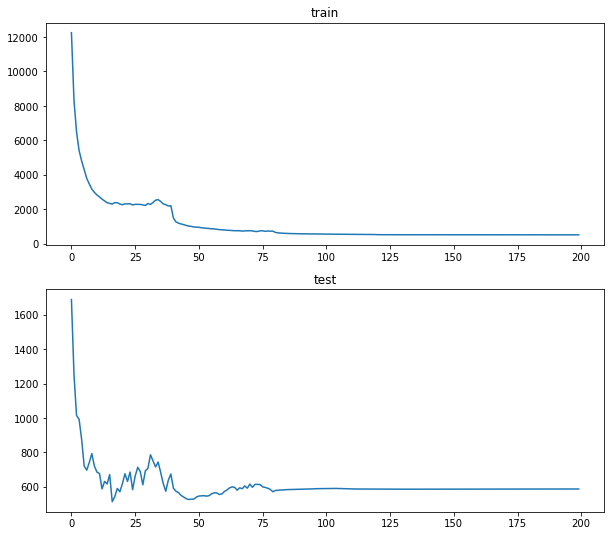

Epoch[200/200] | loss train:511.339707, test:586.344397 | lr:0.000000


In [16]:
def run_epoch(train_inout_seq, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for seq, label in train_inout_seq:
        if is_training:
            optimizer.zero_grad()
            
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size).to('cuda'),
                        torch.zeros(1, 1, model.hidden_layer_size).to('cuda'))
        y_pred = model(seq.to('cuda'))

        
        loss = criterion(y_pred, label.to('cuda'))

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += loss.detach().item() 

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr

# define optimizer, scheduler and loss function
criterion = gevl_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.98), eps=1e-9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

losses_train = []
losses_test = []
# begin training
for epoch in range(200):
    loss_train, lr_train = run_epoch(train_inout_seq, is_training=True)
    loss_val, lr_val = run_epoch(test_inout_seq)
    scheduler.step()
    losses_train.append(loss_train)
    losses_test.append(loss_val)
    
    clear_output(True)
    fig = plt.figure(figsize=(10, 9))
    
    ax_1 = fig.add_subplot(2, 1, 1)
    ax_2 = fig.add_subplot(2, 1, 2)
    ax_1.set_title('train')
    ax_1.plot(losses_train)
    ax_2.set_title('test')
    ax_2.plot(losses_test)
    plt.show()
    
    print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
              .format(epoch+1, 200, loss_train, loss_val, lr_train))

In [10]:
torch.save(model.state_dict(), "./New_loss")

In [11]:
model.eval()
model.to('cpu')
k = 1
last_k_step = test_norm[:k].tolist()
prediction = []
for seq, label in test_inout_seq:
    loop_steps = seq.tolist()
    #print(len(last_k_step))
    for j in range(k):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(torch.FloatTensor(loop_steps).view(-1))
        loop_steps.append(y_pred.detach()[0].item())
        loop_steps = loop_steps[1:]
        #print(len(loop_steps))
    clear_output(True)
    prediction.append(loop_steps[-1])
    #last_k_step.append(test_norm[i])
    #last_k_step = last_k_step[1:]

In [13]:
(((np.array(prediction)*std+mean - np.array(test[20:]))**2).mean())**0.5

0.0881137785774195

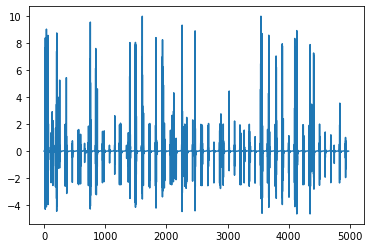

In [14]:
plt.plot(prediction)

In [17]:
model.eval()
model.to('cpu')
k = 1
last_k_step = test_norm[:k].tolist()
prediction = []
for seq, label in test_inout_seq:
    loop_steps = seq.tolist()
    #print(len(last_k_step))
    for j in range(k):
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        y_pred = model(torch.FloatTensor(loop_steps).view(-1))
        loop_steps.append(y_pred.detach()[0].item())
        loop_steps = loop_steps[1:]
        #print(len(loop_steps))
    clear_output(True)
    prediction.append(loop_steps[-1])
    #last_k_step.append(test_norm[i])
    #last_k_step = last_k_step[1:]

In [18]:
(((np.array(prediction)*std+mean - np.array(test[20:]))**2).mean())**0.5

0.10731373430071295